# Nicolas
---

## Importing stuff

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math

In [2]:
maps_dir = 'maps/'

---
## Loading data

* **route**

In [3]:
routes = pd.read_csv('data/routes.dat', sep=',', encoding='utf-8')
routes.columns = ['Airline','AirlineID','SourceAirport','SourceAirportID','DestinationAirport','DestinationAirportID','Codeshare','Stops','Equipment']
routes.head(2)

Airline AirlineID SourceAirport SourceAirportID DestinationAirport  \
0      2B       410           ASF            2966                KZN   
1      2B       410           ASF            2966                MRV   

  DestinationAirportID Codeshare  Stops Equipment  
0                 2990       NaN      0       CR2  
1                 2962       NaN      0       CR2

* **airlines**

In [4]:
airlines = pd.read_csv('data/airlines.dat', sep=',', encoding='utf-8')
airlines.columns = ['AirlineID', 'Name', 'Alias',  'IATA', 'ICAO','Callsign','Country','Active']
airlines.head(2)

AirlineID            Name Alias IATA ICAO Callsign        Country Active
0          1  Private flight    \N    -  NaN      NaN            NaN      Y
1          2     135 Airways    \N  NaN  GNL  GENERAL  United States      N

* **airports**

In [5]:
airports = pd.read_csv('data/airports.dat', sep=',', encoding='utf-8')
airports.columns = ['AirportID', 'Name', 'City', 'Country', 'IATA', 'ICAO','Latitude','Longitude','Altitude', 'Timezone','DST', 'TzdatabaseTimeZone', 'Type', 'Source']
airports.head(2)

AirportID                          Name         City           Country  \
0          2                Madang Airport       Madang  Papua New Guinea   
1          3  Mount Hagen Kagamuga Airport  Mount Hagen  Papua New Guinea   

  IATA  ICAO  Latitude   Longitude Altitude Timezone DST  \
0  MAG  AYMD  -5.20708  145.789001       20       10   U   
1  HGU  AYMH  -5.82679  144.296005     5388       10   U   

     TzdatabaseTimeZone     Type       Source  
0  Pacific/Port_Moresby  airport  OurAirports  
1  Pacific/Port_Moresby  airport  OurAirports

* **alliances**

In [6]:
alliances = pd.read_csv('data/alliances.dat', sep=',', encoding='utf-8')
alliances.head(2)

Alliance IATA  Region
0  Star Alliance   JP  Europe
1  Star Alliance   A3  Europe

In [7]:
alliances.shape

(60, 3)

All the airlines from `alliances.dat` now have a correspondance in the airlines data base with the rigth name.

---
## Creating some array

From Marie's work :

In [8]:
airl_alliances  = pd.merge(alliances, airlines, left_on='IATA', right_on='IATA', how = 'left')[['Alliance', 'Name', 'IATA', 'Country']]
airl_alliances.head(2)

Alliance             Name IATA   Country
0  Star Alliance    Adria Airways   JP  Slovenia
1  Star Alliance  Aegean Airlines   A3    Greece

In [9]:
routes_alce = pd.merge(routes, airl_alliances, left_on = 'Airline', right_on = 'IATA', how = 'left')
routes_alce.head(2)

Airline AirlineID SourceAirport SourceAirportID DestinationAirport  \
0      2B       410           ASF            2966                KZN   
1      2B       410           ASF            2966                MRV   

  DestinationAirportID Codeshare  Stops Equipment Alliance Name IATA Country  
0                 2990       NaN      0       CR2      NaN  NaN  NaN     NaN  
1                 2962       NaN      0       CR2      NaN  NaN  NaN     NaN

In [10]:
routes_alce[~routes_alce.IATA.isnull()].Airline.count()

31134

In [11]:
routes_alce_only = routes_alce[~routes_alce.IATA.isnull()]
routes_alce_only.head(2)

Airline AirlineID SourceAirport SourceAirportID DestinationAirport  \
4237      A3        96           AOK            1459                ATH   
4238      A3        96           AOK            1459                KSJ   

     DestinationAirportID Codeshare  Stops Equipment       Alliance  \
4237                 3941       NaN      0       DH4  Star Alliance   
4238                 1461       NaN      0       DH8  Star Alliance   

                 Name IATA Country  
4237  Aegean Airlines   A3  Greece  
4238  Aegean Airlines   A3  Greece

---
## Adjacency matrices

Here I'm just replacing the nan by a "None" string to simplify comparison later.

In [12]:
routes_alce = routes_alce.fillna("None")
routes_alce.head(2)

Airline AirlineID SourceAirport SourceAirportID DestinationAirport  \
0      2B       410           ASF            2966                KZN   
1      2B       410           ASF            2966                MRV   

  DestinationAirportID Codeshare  Stops Equipment Alliance  Name  IATA Country  
0                 2990      None      0       CR2     None  None  None    None  
1                 2962      None      0       CR2     None  None  None    None

Recreation of the indexes for the destinations and sources airport adapted from milestone 1.

In [13]:
# import of source and destination airport
source_airports = routes[['SourceAirport']]
source_airports = source_airports.rename(columns={'SourceAirport':'Airport'})

dest_airports = routes[['DestinationAirport']]
dest_airports = dest_airports.rename(columns={'DestinationAirport':'Airport'})

# creation of a dataframe with all airport and airport_idx 
# (we use airport_idx insteed of airportID because some airports have no airportID)
airportsID = pd.concat([source_airports,dest_airports]).drop_duplicates().reset_index().drop(columns=['index']).reset_index()
airportsID = airportsID.set_index('Airport').rename(columns={'index':'airportsID'})
airportsID.head(2)

airportsID
Airport            
ASF               0
CEK               1

Creation of the weighted adjacency matrix. We first create a 3D tensor with dimensions {source, destination, alliance}. That way we can keep the weight intact for each flight.
* No edges = 0
* No alliances = 1
* Star Alliance = 2
* One World = 3
* SkyTeam = 4

In [14]:
alliances_idx = {"None":1, "Star Alliance":2, "One World":3, "SkyTeam":4}
alliances_idx["None"]

1

In [15]:
n_nodes = len(airportsID)
adjacency = np.zeros((n_nodes, n_nodes, 5), dtype=int)
for idx,row in routes_alce.iterrows():
    
    idx_source = airportsID.loc[row.SourceAirport, "airportsID"]
    idx_dest = airportsID.loc[row.DestinationAirport, "airportsID"]
    category = alliances_idx[row.Alliance]
    
    adjacency[idx_source, idx_dest, category] += 1
    adjacency[idx_dest, idx_source, category] += 1

For exemple, this is the adjacency of the first 15 airports that are not in any alliances and then from SkyTeam.

In [16]:
# view of a part of adjacency
print(adjacency[:15, :15, 1])
print(adjacency[:15, :15, 4])

[[ 0  0  2  0  0  0  2  2  2  0  0  0  0  0  0]
 [ 0  0  2  0  0  0  2  0  0  0  0  0  4  0  0]
 [ 2  2  0  6  2  4  6  6  4  2  2  4  4  4  2]
 [ 0  0  6  0  0  2  2  2  0  0  0  0  0  0  0]
 [ 0  0  2  0  0  0  0  2  2  2  0  0  2  4  0]
 [ 0  0  4  2  0  0  0  0  0  0  0  0  0  0  0]
 [ 2  2  6  2  0  0  0  4  0  0  0  0  0  2  0]
 [ 2  0  6  2  2  0  4  0  0  2  0  0  2  2  0]
 [ 2  0  4  0  2  0  0  0  0  0  0  0  0  4  0]
 [ 0  0  2  0  2  0  0  2  0  0  0  0  0  2  0]
 [ 0  0  2  0  0  0  0  0  0  0  0  0  6  4  0]
 [ 0  0  4  0  0  0  0  0  0  0  0  0  2  4  0]
 [ 0  4  4  0  2  0  0  2  0  0  6  2  0 10  0]
 [ 0  0  4  0  4  0  2  2  4  2  4  4 10  0  0]
 [ 0  0  2  0  0  0  0  0  0  0  0  0  0  0  0]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 2 0 0 0 0 0 0 0]
 [0 2 2 0 2 2 2 0 2 0 0 0 2 2 0]
 [0 0 0 0 0 0 0

We may want to flatten this array. We can associate each travel (source, destination) with the alliance that have the most flight on it :

In [17]:
MaXdjacency = np.argmax(adjacency, axis=2)
print("This is indeed a" , MaXdjacency.shape, "matrix.")
MaXdjacency[:15, :15]

This is indeed a (3425, 3425) matrix.


array([[0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 1, 4, 0, 0, 0, 0, 1, 0, 0],
       [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0],
       [0, 0, 1, 1, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0],
       [1, 4, 1, 1, 1, 4, 1, 0, 4, 1, 0, 0, 1, 1, 0],
       [1, 0, 1, 0, 1, 0, 0, 4, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
       [0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0],
       [0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [18]:
print("The number of edges is now", (MaXdjacency != 0).sum())
print("The number of edges from an alliances is now", np.logical_and((MaXdjacency != 0),(MaXdjacency != 1)).sum())

The number of edges is now 38513
The number of edges from an alliances is now 11264


**Note :** The selection of the label for each flight by the argmax can be unfair because there are many more airlines that are not in alliances and therefore possibly higther weigth for the "None" category. Other methods can be found. For exemples we could normalize by the number of airlines by category for each fligth. We can discuss that. But the whole information is anyway in the 3D adjacency.

---
## Some tests for later

Paris's main airport is Paris Charles de Gaulle (CDG). Let's see the connection of that airport.

In [19]:
cdg_idx = airportsID.loc["CDG", "airportsID"]

Text(0.5, 1.0, 'Number of flight by alliances in the CDG airport')

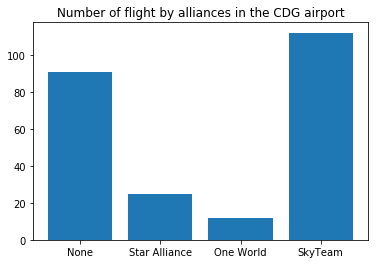

In [20]:
#height,x = np.histogram(MaXdjacency[cdg_idx, :], [0, 1, 2, 3, 4])

y = np.bincount(MaXdjacency[cdg_idx, :])[1:] # To ignore the 0 where ther is no edge
plt.xticks(list(alliances_idx.values()), list(alliances_idx.keys()))
plt.bar(list(alliances_idx.values()), y)
plt.title("Number of flight by alliances in the CDG airport")

We can then say that this airport is "controled" by SkyTeam. This seems reasonable as AirFrance is indeed in this alliance.

Now let's assign each airport with a alliance tag :

In [21]:
airport_tag = np.zeros(airportsID.size, dtype = int)
for name,airport in airportsID.iterrows():
    counts = np.bincount(MaXdjacency[airport.airportsID, :])[1:]
    values = np.unique(MaXdjacency[airport.airportsID, :])
    values = list(range(values.min(), values.max()+1))[1:]
    maxi = np.argmax(counts)
    airport_tag[airport.airportsID] = values[maxi]

In [22]:
tags = np.array(list(alliances_idx.keys()))[airport_tag-1]
print(tags)

['None' 'None' 'None' ... 'None' 'None' 'None']


In [23]:
print(np.unique(tags))
print(np.unique(airport_tag))

['None' 'One World' 'SkyTeam' 'Star Alliance']
[1 2 3 4]


Text(0.5, 1.0, 'Number of airport controled by each alliances')

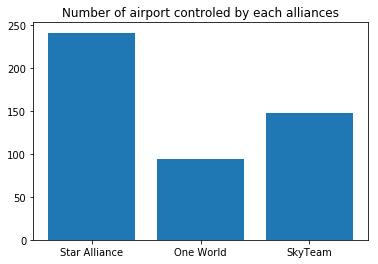

In [24]:
plt.xticks(list(alliances_idx.values())[1:], list(alliances_idx.keys())[1:])
plt.bar(list(alliances_idx.values())[1:],  np.bincount(airport_tag)[2:])
plt.title("Number of airport controled by each alliances")

---
## Projections and vizualisation

In [25]:
import folium
#pip install folium

First, let's create a map of the airports :

In [26]:
airports.head(2)

AirportID                          Name         City           Country  \
0          2                Madang Airport       Madang  Papua New Guinea   
1          3  Mount Hagen Kagamuga Airport  Mount Hagen  Papua New Guinea   

  IATA  ICAO  Latitude   Longitude Altitude Timezone DST  \
0  MAG  AYMD  -5.20708  145.789001       20       10   U   
1  HGU  AYMH  -5.82679  144.296005     5388       10   U   

     TzdatabaseTimeZone     Type       Source  
0  Pacific/Port_Moresby  airport  OurAirports  
1  Pacific/Port_Moresby  airport  OurAirports

In [27]:
airportsID.head(2)

airportsID
Airport            
ASF               0
CEK               1

In [28]:
airportsID["IATA"] = airportsID.index
airportsIDnb = airportsID.set_index("airportsID")

In [29]:
airportsIDnb.head(2)

IATA
airportsID     
0           ASF
1           CEK

In [30]:
airportsIDnb = airportsID.set_index("airportsID")
geoData = pd.merge(airportsIDnb, airports, left_on="IATA", right_on="IATA", how="left")[["IATA", "Name", "Latitude", "Longitude"]]
#geoData = geoData.set_index("IATA")
#geoData['alliance'] = airport_tag
geoDataIATA = geoData.set_index("IATA")
geoData.head()

IATA                                 Name   Latitude  Longitude
0  ASF                    Astrakhan Airport  46.283298  48.006302
1  CEK        Chelyabinsk Balandino Airport  55.305801  61.503300
2  DME     Domodedovo International Airport  55.408798  37.906300
3  EGO       Belgorod International Airport  50.643799  36.590099
4  GYD  Heydar Aliyev International Airport  40.467499  50.046700

In [31]:
geoData[geoData["Name"].isnull()].shape

(239, 4)

In [32]:
colors = ['#969696', '#FF0000', '#00FF00', '#0000FF']

In [33]:
m = folium.Map()

In [34]:
for idx,row in geoData.iterrows():
    #print(row.alliance)
    color = colors[airport_tag[idx]-1]
    if airport_tag[idx]>1:
        r = 7
    else:
        r = 1
    if pd.isna(row.Latitude) is False:
        folium.Circle(
            location=[row.Latitude, row.Longitude],
            radius=10000*r,
            color=color,
            stroke=False,
            fill=True,
            fill_opacity=0.6,
            tooltip=row.Name
        ).add_to(m)

All the airport are plot in the following map

In [35]:
m

In [36]:
m.save('airports_discret.html')

Now the edges : (Don't run that with a potato PC)

In [37]:
kw = {'opacity':0.1, 'weight': 0.4}

for idx,row in routes.iterrows():
    Lat_s = geoDataIATA.loc[row.SourceAirport,"Latitude"]
    Lat_d = geoDataIATA.loc[row.DestinationAirport,"Latitude"]
    Long_s = geoDataIATA.loc[row.SourceAirport,"Longitude"]
    Long_d = geoDataIATA.loc[row.DestinationAirport,"Longitude"]
    if pd.isna(Lat_s) is False and pd.isna(Lat_d) is False:
        folium.PolyLine(
            locations=[(Lat_s, Long_s), (Lat_d, Long_d)],
            line_cap='butt',
            color='cornflowerblue',
            **kw,
        ).add_to(m)

In [38]:
#m

In [39]:
#m.save(maps_dir+'airports_routes.html')

---
## Label assignment

In [40]:
airport_colors = [None] * airportsID.shape[0]

for airport in airportsID.airportsID :
    SA = np.sum(adjacency[airport, :, 2])
    OW = np.sum(adjacency[airport, :, 3])
    ST = np.sum(adjacency[airport, :, 4])
    p = np.array([SA, OW, ST])
    norm = np.linalg.norm(p)
    if (norm != 0):
        p = p/norm*255
    airport_colors[airport]='#%02x%02x%02x'%(int(p[0]), int(p[1]), int(p[2]))
#airport_colors

In [41]:
m1 = folium.Map(tiles='cartodbdark_matter',  location=[14, 10], zoom_start=1.5)
for idx,row in geoData.iterrows():
    #print(row.alliance)
    color = airport_colors[idx]
    if color =="#000000":
        r = 1
    else:
        r = 2
    if pd.isna(row.Latitude) is False:
        folium.CircleMarker(
            location=[row.Latitude, row.Longitude],
            radius=2*r,
            color=color,
            stroke=False,
            fill=True,
            fill_opacity=0.6,
            tooltip=row.Name
        ).add_to(m1)
#airport_attribution

In [42]:
#m1

In [43]:
#m1.save('airports_continuous.html')

## Skyteam

In [44]:
skyteam_adj = adjacency[:, :, 4]
skyteam_selector = np.zeros(skyteam_adj.shape[0])

for airport in airportsID.airportsID :
    ST = np.sum(skyteam_adj[airport, :])
    #print(airport)
    if ST != 0:
        skyteam_selector[airport]=1
    else:
        skyteam_selector[airport]=0
    
skyteam_selector

array([1., 1., 1., ..., 0., 0., 0.])

In [45]:
m_ST = folium.Map(tiles='cartodbdark_matter',  location=[14, 10], zoom_start=1.5)
for idx,row in geoData.iterrows():
    #print(row.alliance)
    if pd.isna(row.Latitude) is False:
        if skyteam_selector[idx] == 1:
            folium.CircleMarker(
                location=[row.Latitude, row.Longitude],
                radius=2*r,
                color='#0000FF',
                stroke=False,
                fill=True,
                fill_opacity=0.6,
                tooltip=row.Name
            ).add_to(m_ST)

for source in range(skyteam_adj.shape[0]):
    for destination in range(skyteam_adj.shape[1]):
        if (skyteam_adj[source,destination]> 0):
            Lat_s = geoData.loc[source,"Latitude"]
            Lat_d = geoData.loc[destination,"Latitude"]
            Long_s = geoData.loc[source,"Longitude"]
            Long_d = geoData.loc[destination,"Longitude"]
            if pd.isna(Lat_s) is False and pd.isna(Lat_d) is False:
                folium.PolyLine(
                    locations=[(Lat_s, Long_s), (Lat_d, Long_d)],
                    line_cap='butt',
                    color='cornflowerblue',
                    opacity = 0.1,
                    weight = 0.4
                ).add_to(m_ST)

In [46]:
#m_ST

In [47]:
#m_ST.save('MapSkyTeam.html')

## Star Alliance 

In [48]:
starAlliance_adj = adjacency[:, :, 2]
starAlliance_selector = np.zeros(starAlliance_adj.shape[0])

for airport in airportsID.airportsID :
    ST = np.sum(starAlliance_adj[airport, :])
    #print(airport)
    if ST != 0:
        starAlliance_selector[airport]=1
    else:
        starAlliance_selector[airport]=0
    
starAlliance_selector

array([1., 0., 1., ..., 0., 0., 0.])

In [49]:
m_SA = folium.Map(tiles='cartodbdark_matter',  location=[14, 10], zoom_start=1.5)
for idx,row in geoData.iterrows():
    #print(row.alliance)
    if pd.isna(row.Latitude) is False:
        if starAlliance_selector[idx] == 1:
            folium.CircleMarker(
                location=[row.Latitude, row.Longitude],
                radius=2*r,
                color='#FF0000',
                stroke=False,
                fill=True,
                fill_opacity=0.6,
                tooltip=row.Name
            ).add_to(m_SA)

for source in range(skyteam_adj.shape[0]):
    for destination in range(starAlliance_adj.shape[1]):
        if (starAlliance_adj[source,destination]> 0):
            Lat_s = geoData.loc[source,"Latitude"]
            Lat_d = geoData.loc[destination,"Latitude"]
            Long_s = geoData.loc[source,"Longitude"]
            Long_d = geoData.loc[destination,"Longitude"]
            if pd.isna(Lat_s) is False and pd.isna(Lat_d) is False:
                folium.PolyLine(
                    locations=[(Lat_s, Long_s), (Lat_d, Long_d)],
                    line_cap='butt',
                    color='#f45757',
                    opacity = 0.1,
                    weight = 0.4
                ).add_to(m_SA)

In [50]:
#m_SA

In [51]:
#m_SA.save('MapStarAlliance.html')

## One World

In [52]:
oneWorld_adj = adjacency[:, :, 3]
oneWorld_selector = np.zeros(oneWorld_adj.shape[0])
for airport in airportsID.airportsID :
    ST = np.sum(oneWorld_adj[airport, :])
    if ST != 0:
        oneWorld_selector[airport]=1
    else:
        oneWorld_selector[airport]=0    
skyteam_selector
m_OW = folium.Map(tiles='cartodbdark_matter',  location=[14, 10], zoom_start=1.5)
for idx,row in geoData.iterrows():
    if pd.isna(row.Latitude) is False:
        if oneWorld_selector[idx] == 1:
            folium.CircleMarker(
                location=[row.Latitude, row.Longitude],
                radius=2*r,
                color='#00FF00',
                stroke=False,
                fill=True,
                fill_opacity=0.6,
                tooltip=row.Name
            ).add_to(m_OW)
for source in range(oneWorld_adj.shape[0]):
    for destination in range(oneWorld_adj.shape[1]):
        if (oneWorld_adj[source,destination]> 0):
            Lat_s = geoData.loc[source,"Latitude"]
            Lat_d = geoData.loc[destination,"Latitude"]
            Long_s = geoData.loc[source,"Longitude"]
            Long_d = geoData.loc[destination,"Longitude"]
            if pd.isna(Lat_s) is False and pd.isna(Lat_d) is False:
                folium.PolyLine(
                    locations=[(Lat_s, Long_s), (Lat_d, Long_d)],
                    line_cap='butt',
                    color='#88ca84',
                    opacity = 0.1,
                    weight = 0.4
                ).add_to(m_OW)
#m_OW

In [53]:
#m_OW.save('MapOneWrld.html')

# Plot Label propagation

In [77]:
airport_attr_all = np.load("generated_data/airport_attr_all.npy")

In [78]:
airport_attr_all = pd.DataFrame(data = airport_attr_all, columns = ["airport", "airportsID", "Star_Alliance", "One_World", "SkyTeam", "labelled", "tolabel", "Star_Alliance_pred", "One_World_pred", "SkyTeam_pred"])


In [79]:
m_OW_pred = folium.Map(tiles='cartodbdark_matter',  location=[14, 10], zoom_start=1.5)
for idx,row in geoData.iterrows():
    if pd.isna(row.Latitude) is False:
        if airport_attr_all.loc[idx,"One_World"] == 1:
            folium.CircleMarker(
                location=[row.Latitude, row.Longitude],
                radius=2*r,
                color='#067c00',
                stroke=False,
                fill=True,
                fill_opacity=0.6,
                tooltip=row.Name
            ).add_to(m_OW_pred)
        elif airport_attr_all.loc[idx,"One_World_pred"] == 1:
            folium.CircleMarker(
                location=[row.Latitude, row.Longitude],
                radius=2*r,
                color='#39ff47',
                stroke=False,
                fill=True,
                fill_opacity=0.6,
                tooltip=row.Name
            ).add_to(m_OW_pred)
            
m_OW_pred.save("MapPredicOW.html")
m_OW_pred

Here the dark blue indicate the current airport, and light blue the predicted airport for One World. 
The sameway for the two other alliance (light = new, dark = current) :

In [80]:
m_ST_pred = folium.Map(tiles='cartodbdark_matter',  location=[14, 10], zoom_start=1.5)
for idx,row in geoData.iterrows():
    if pd.isna(row.Latitude) is False:
        if airport_attr_all.loc[idx,"SkyTeam"] == 1:
            folium.CircleMarker(
                location=[row.Latitude, row.Longitude],
                radius=2*r,
                color='#00008f',
                stroke=False,
                fill=True,
                fill_opacity=0.6,
                tooltip=row.Name
            ).add_to(m_ST_pred)
        elif airport_attr_all.loc[idx,"SkyTeam_pred"] == 1:
            folium.CircleMarker(
                location=[row.Latitude, row.Longitude],
                radius=2*r,
                color='#8ce3ff',
                stroke=False,
                fill=True,
                fill_opacity=0.6,
                tooltip=row.Name
            ).add_to(m_ST_pred)
m_ST_pred.save("MapPredicST.html")
m_ST_pred

In [81]:
m_SA_pred = folium.Map(tiles='cartodbdark_matter',  location=[14, 10], zoom_start=1.5)
for idx,row in geoData.iterrows():
    if pd.isna(row.Latitude) is False:
        if airport_attr_all.loc[idx,"Star_Alliance"] == 1:
            folium.CircleMarker(
                location=[row.Latitude, row.Longitude],
                radius=2*r,
                color='#620000',
                stroke=False,
                fill=True,
                fill_opacity=0.6,
                tooltip=row.Name
            ).add_to(m_SA_pred)
        elif airport_attr_all.loc[idx,"Star_Alliance_pred"] == 1:
            folium.CircleMarker(
                location=[row.Latitude, row.Longitude],
                radius=2*r,
                color='#ff0000',
                stroke=False,
                fill=True,
                fill_opacity=0.6,
                tooltip=row.Name
            ).add_to(m_SA_pred)
m_SA_pred.save("MapPredicSA.html")
m_SA_pred